<a href="https://colab.research.google.com/github/AdrianGuel/AdrianGuel.github.io/blob/main/MachineLearningbits/RL_cartpendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Download and import the MIT 6.S191 package
!printf "Installing MIT deep learning package... "
!pip install --upgrade git+https://github.com/aamini/introtodeeplearning.git &> /dev/null
!echo "Done"

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Installing MIT deep learning package... Done


In [ ]:
#Install some dependencies for visualizing the agents
!apt-get install -y xvfb python-opengl x11-utils &> /dev/null
!pip install gym pyvirtualdisplay scikit-video ffio pyrender &> /dev/null
!pip install tensorflow_probability==0.12.0 &> /dev/null
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import numpy as np
import matplotlib, cv2
import matplotlib.pyplot as plt
import base64, io, os, time, gym
import IPython, functools
import time
from tqdm import tqdm
import tensorflow_probability as tfp

import mitdeeplearning as mdl

In [ ]:
### Instantiate the Cartpole environment ###

env = gym.make("CartPole-v1")
env.seed(1)
n_observations = env.observation_space
print("Environment has observation space =", n_observations)
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

### Define the Cartpole agent ###

# Defines a feed-forward neural network
def create_cartpole_model():
    model = tf.keras.models.Sequential([
        # First Dense layer
        tf.keras.layers.Dense(units=32, activation='relu'),
        
        # TODO: Define the last Dense layer, which will provide the network's output.
        # Think about the space the agent needs to act in!
        tf.keras.layers.Dense(units=n_actions, activation=None) # TODO
        # ['''TODO''' Dense layer to output action probabilities]
    ])
    return model

cartpole_model = create_cartpole_model()

### Define the agent's action function ###

# Function that takes observations as input, executes a forward pass through model, 
#   and outputs a sampled action.
# Arguments:
#   model: the network that defines our agent
#   observation: observation(s) which is/are fed as input to the model
#   single: flag as to whether we are handling a single observation or batch of
#     observations, provided as an np.array
# Returns:
#   action: choice of agent action
def choose_action(model, observation, single=True):
    # add batch dimension to the observation if only a single example was provided
    observation = np.expand_dims(observation, axis=0) if single else observation

    '''TODO: feed the observations through the model to predict the log probabilities of each possible action.'''
    logits = model.predict(observation) # TODO
    # logits = model.predict('''TODO''')

    '''TODO: Choose an action from the categorical distribution defined by the log 
       probabilities of each possible action.'''
    action = tf.random.categorical(logits, num_samples=1)
    # action = ['''TODO''']

    action = action.numpy().flatten()

    return action[0] if single else action


Environment has observation space = Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Number of possible actions that the agent can choose from = 2


In [ ]:
### Agent Memory ###

class Memory:
    def __init__(self): 
        self.clear()

  # Resets/restarts the memory buffer
    def clear(self): 
        self.observations = []
        self.actions = []
        self.rewards = []

  # Add observations, actions, rewards to memory
    def add_to_memory(self, new_observation, new_action, new_reward): 
        self.observations.append(new_observation)
        '''TODO: update the list of actions with new action'''
        self.actions.append(new_action) # TODO
        # ['''TODO''']
        '''TODO: update the list of rewards with new reward'''
        self.rewards.append(new_reward) # TODO
        # ['''TODO''']

    def __len__(self):
        return len(self.actions)

# Instantiate a single Memory buffer
memory = Memory()

### Reward function ###

# Helper function that normalizes an np.array x
def normalize(x):
    x -= np.mean(x)
    x /= np.std(x)
    return x.astype(np.float32)

# Compute normalized, discounted, cumulative rewards (i.e., return)
# Arguments:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor
# Returns:
#   normalized discounted reward
def discount_rewards(rewards, gamma=0.95): 
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        # update the total discounted reward
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R
      
    return normalize(discounted_rewards)

In [ ]:
### Loss function ###

# Arguments:
#   logits: network's predictions for actions to take
#   actions: the actions the agent took in an episode
#   rewards: the rewards the agent received in an episode
# Returns:
#   loss
def compute_loss(logits, actions, rewards): 
    '''TODO: complete the function call to compute the negative log probabilities'''
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=actions) # TODO
    # neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(
    #    logits='''TODO''', labels='''TODO''')
  
    '''TODO: scale the negative log probability by the rewards'''
    loss = tf.reduce_mean( neg_logprob * rewards ) # TODO
    # loss = tf.reduce_mean('''TODO''')
    return loss

In [ ]:
### Training step (forward and backpropagation) ###

def train_step(model, loss_function, optimizer, observations, actions, discounted_rewards, custom_fwd_fn=None):
    with tf.GradientTape() as tape:
        # Forward propagate through the agent network
        if custom_fwd_fn is not None:
            prediction = custom_fwd_fn(observations)
        else: 
            prediction = model(observations)

        '''TODO: call the compute_loss function to compute the loss'''
        loss = loss_function(prediction, actions, discounted_rewards) # TODO
        # loss = loss_function('''TODO''', '''TODO''', '''TODO''')

    '''TODO: run backpropagation to minimize the loss using the tape.gradient method. 
             Unlike supervised learning, RL is *extremely* noisy, so you will benefit 
             from additionally clipping your gradients to avoid falling into 
             dangerous local minima. After computing your gradients try also clipping
             by a global normalizer. Try different clipping values, usually clipping 
             between 0.5 and 5 provides reasonable results. '''
    grads = tape.gradient(loss, model.trainable_variables) # TODO
    # grads = tape.gradient('''TODO''', '''TODO''')
    grads, _ = tf.clip_by_global_norm(grads, 2)
    # grads, _ = tf.clip_by_global_norm(grads, '''TODO''')
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
## Training parameters ##
## Re-run this cell to restart training from scratch ##

# TODO: Learning rate and optimizer
learning_rate = 1e-3
# learning_rate = '''TODO'''
optimizer = tf.keras.optimizers.Adam(learning_rate)
# optimizer = '''TODO'''

# instantiate cartpole agent
cartpole_model = create_cartpole_model()

# to track our progress
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.95)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

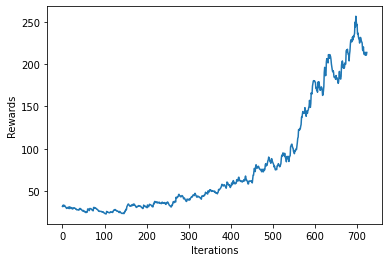

In [ ]:
## Cartpole training! ##
## Note: stoping and restarting this cell will pick up training where you
#        left off. To restart training you need to rerun the cell above as 
#        well (to re-initialize the model and optimizer)

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i_episode in range(500):

    plotter.plot(smoothed_reward.get())
    # Restart the environment
    observation = env.reset()
    memory.clear()

    while True:
        # using our observation, choose an action and take it in the environment
        action = choose_action(cartpole_model, observation)
        next_observation, reward, done, info = env.step(action)
        # add to memory
        memory.add_to_memory(observation, action, reward)

        # is the episode over? did you crash or do so well that you're done?
        if done:
            # determine total reward and keep a record of this
            total_reward = sum(memory.rewards)
            smoothed_reward.append(total_reward)
          
            # initiate training - remember we don't know anything about how the 
            #   agent is doing until it has crashed!
            g = train_step(cartpole_model, compute_loss, optimizer, 
                       observations=np.vstack(memory.observations),
                       actions=np.array(memory.actions),
                       discounted_rewards = discount_rewards(memory.rewards))
          
            # reset the memory
            memory.clear()
            break
        # update our observatons
        observation = next_observation

In [ ]:
matplotlib.use('Agg') 
saved_cartpole = mdl.lab3.save_video_of_model(cartpole_model, "CartPole-v1")
mdl.lab3.play_video(saved_cartpole)

Successfully saved 500 frames into CartPole-v1.mp4!
